# LAB 5
### Hecho por: Joshua Sancho y Steven Solís

## Librerías

In [1]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

## Entendimiento de los Datos

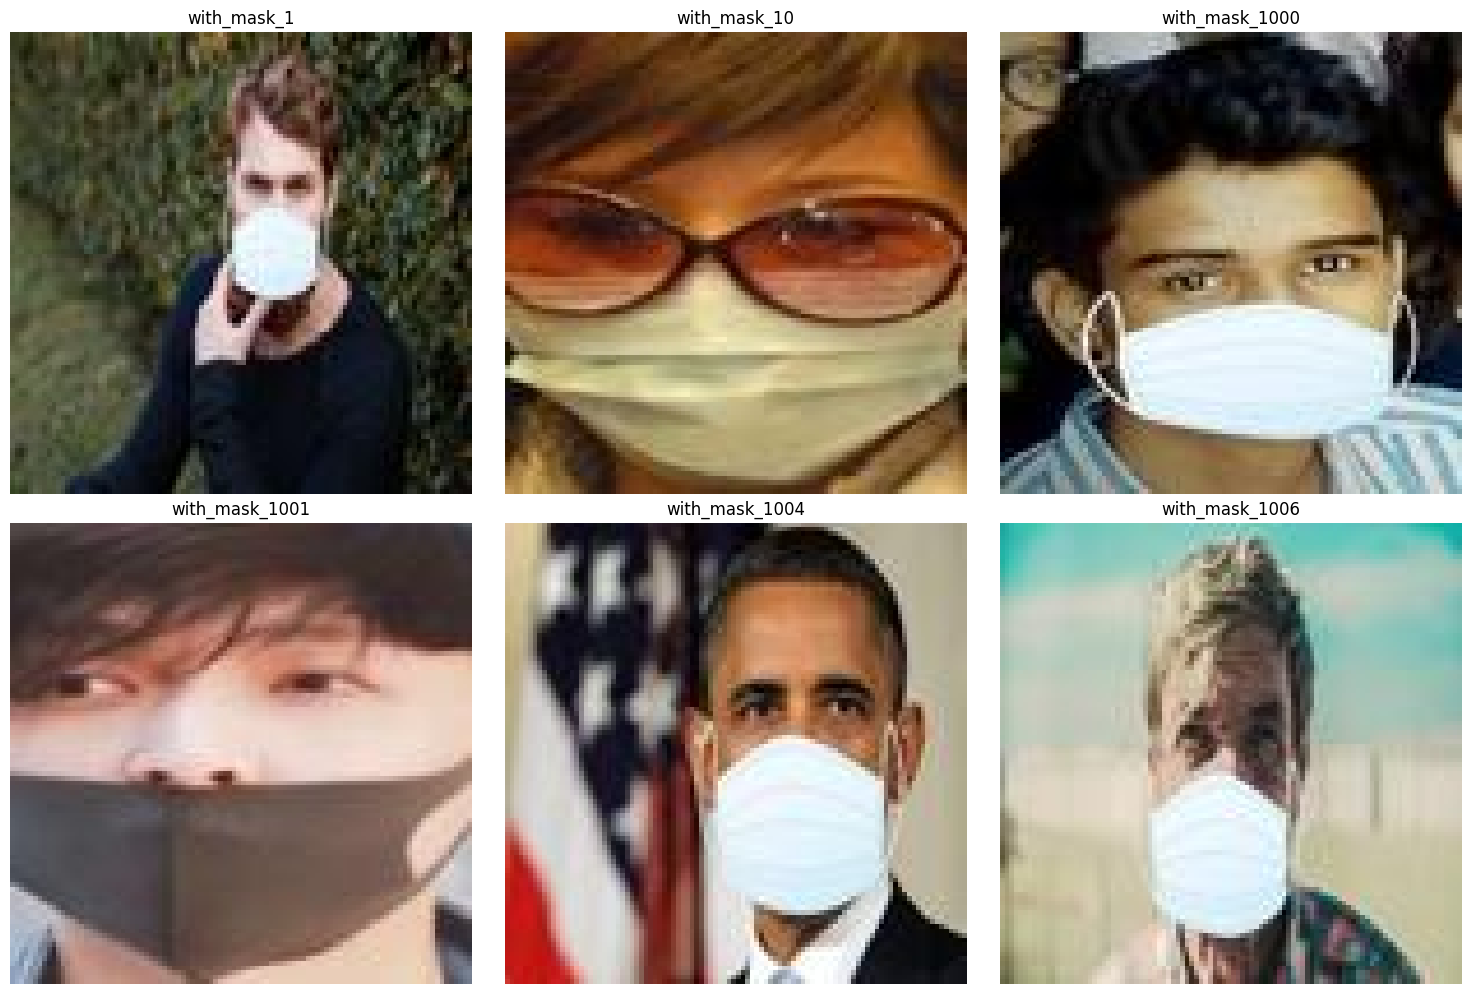

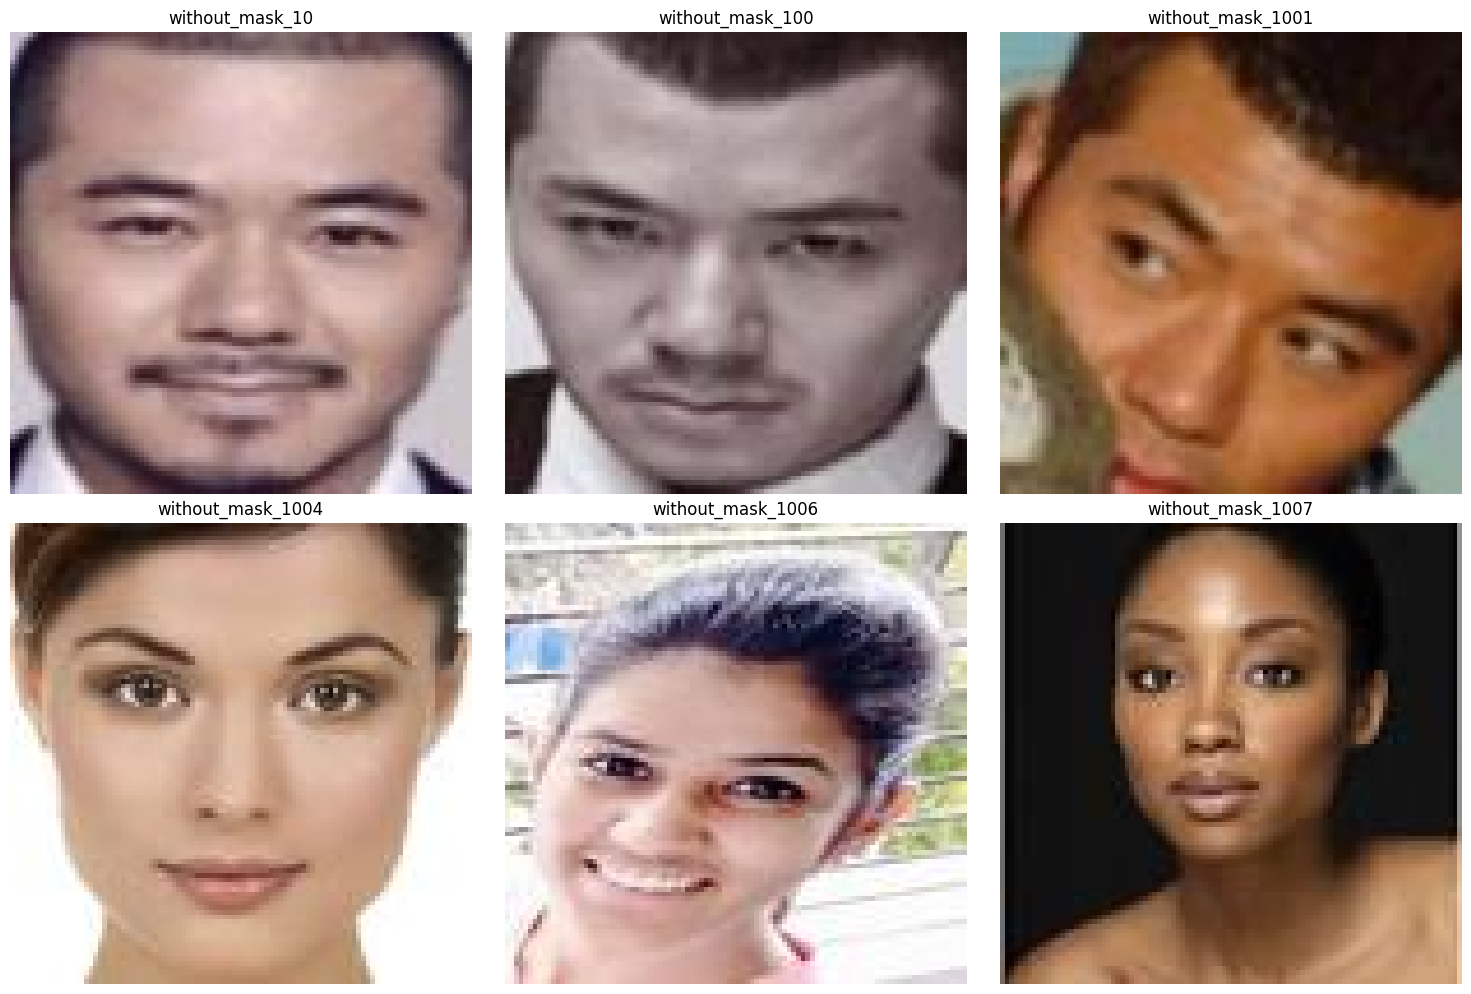

In [4]:
def display_images_with_labels(path, num_images=6):
    # Get a list of all image file names in the directory
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Display the images with their labels
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(num_images, len(image_files))):
        # Get the image file name and its label
        image_file = image_files[i]
        label = image_file.split('.')[0]

        # Load and display the image
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Example usage:
path = "dataset_preprocessed/train/with_mask"
display_images_with_labels(path)

path = "dataset_preprocessed/train/without_mask"
display_images_with_labels(path)

## Procesamiento de Datos

In [5]:
# Define data augmentation and normalization parameters for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # Rotate images randomly up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally up to 20% of the width
    height_shift_range=0.2, # Shift images vertically up to 20% of the height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Zoom in randomly up to 20%
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill in newly created pixels after rotation or shifting
)

# Create a data generator for training data with one-hot encoded labels
train_generator = train_datagen.flow_from_directory(
    'dataset_preprocessed/train',
    target_size=(100, 100),
    batch_size=10,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=True)  # Shuffle the data

# Define data augmentation and normalization parameters for validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a data generator for validation data with one-hot encoded labels
val_generator = val_datagen.flow_from_directory(
    'dataset_preprocessed/val',
    target_size=(100, 100),
    batch_size=10,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=False)  # No need to shuffle validation data

Found 5286 images belonging to 2 classes.
Found 757 images belonging to 2 classes.


## Modelo de Deep Learning

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [9]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Compile the model with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Change the loss function
              metrics=['accuracy'])

# Train the model for 100 epochs
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
529/529 [==============================] - 25s 47ms/step - loss: 0.4898 - accuracy: 0.7764 - val_loss: 0.3442 - val_accuracy: 0.8930
Epoch 2/100
529/529 [==============================] - 10s 19ms/step - loss: 0.3694 - accuracy: 0.8441 - val_loss: 0.2246 - val_accuracy: 0.9194
Epoch 3/100
529/529 [==============================] - 10s 18ms/step - loss: 0.3295 - accuracy: 0.8678 - val_loss: 0.2369 - val_accuracy: 0.8983
Epoch 4/100
529/529 [==============================] - 10s 18ms/step - loss: 0.3030 - accuracy: 0.8808 - val_loss: 0.2219 - val_accuracy: 0.9022
Epoch 5/100
529/529 [==============================] - 10s 19ms/step - loss: 0.2954 - accuracy: 0.8795 - val_loss: 0.1643 - val_accuracy: 0.9379
Epoch 6/100
529/529 [==============================] - 10s 18ms/step - loss: 0.2697 - accuracy: 0.8939 - val_loss: 0.1691 - val_accuracy: 0.9353
Epoch 7/100
529/529 [==============================] - 10s 18ms/step - loss: 0.2611 - accuracy: 0.8994 - val_loss: 0.1745 - val_ac

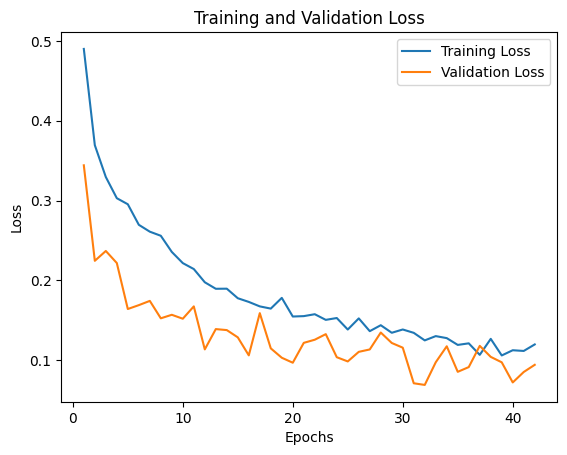

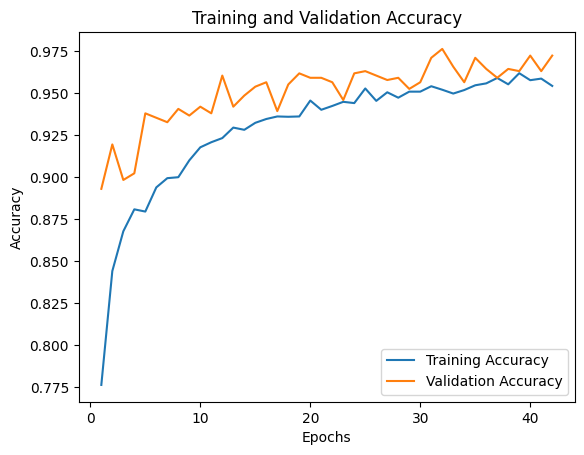

In [10]:
# Get the training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Get the validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Save the trained model
model.save("mask.keras")

## Predicción y Evaluación

In [14]:
# Define data augmentation and normalization parameters for validation data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a data generator for validation data with one-hot encoded labels
test_generator = test_datagen.flow_from_directory(
    'dataset_preprocessed/test',
    target_size=(100, 100),
    batch_size=5,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=False)  # No need to shuffle validation data

Found 1510 images belonging to 2 classes.


302/302 [==============================] - 5s 16ms/step - loss: 0.0752 - accuracy: 0.9748
Test Loss: 0.07517839968204498
Test Accuracy: 0.9748344421386719
302/302 [==============================] - 1s 3ms/step


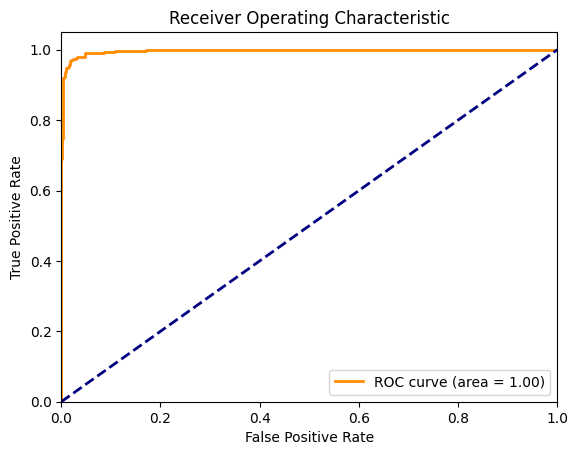

In [15]:
model.load_weights('mask.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get the true labels and predicted probabilities for the test data
true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)

# Plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Conclusión
En resumen, el modelo alcanzó una alta precisión (accuracy) tanto en los datos de entrenamiento como en los de validación, con valores que oscilaron alrededor del 95% en promedio. Durante las últimas épocas del entrenamiento la precisión en los datos de validación se mantuvo alta, alcanzando hasta un 98.67%, lo que indica que el modelo generalizó bien a datos no vistos. 

Basándonos en los resultados obtenidos, el modelo alcanzó una precisión (accuracy) del 98.08% en los datos de prueba, con una pérdida (loss) de aproximadamente 0.072. Estos resultados indican que el modelo generaliza bien a datos no vistos, ya que mantiene una alta precisión en los datos de prueba. Es importante destacar que la pérdida y la precisión obtenidas en los datos de prueba son consistentes con las métricas observadas durante el entrenamiento y validación del modelo, lo que sugiere que el modelo no ha sufrido de sobreajuste y que ha aprendido patrones generalizables de los datos de entrenamiento.